In [15]:
# Importing necessary libraries
from support.funcs import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pptx import Presentation
from pptx.util import Inches
import json
import os
from io import BytesIO
from scipy.signal import savgol_filter
from scipy.stats import pearsonr
from pptx.util import Pt

current_directory = os.getcwd()
# Read the JSON file containing the Session Directory
with open(current_directory+'\\SessionDirectory.json', 'r') as file:
    session_data = json.load(file)
    
# Get the directory path from the JSON data
pth = session_data["directory"]

# Getting the mocap data
df_mocap,starttime=read_df_csv(pth+'\\mocap.csv')

# converting to epoch time
epoch_time = starttime.timestamp() 
time=df_mocap['seconds'].to_numpy()
time=time+epoch_time
df_mocap.insert(1,'epoch_time',time)
df_mocap.drop(columns=['seconds'],inplace=True)
df_mocap.sort_values(by=['epoch_time'])

# applying savgol filter to mocap data 
df_mocap = pd.DataFrame(savgol_filter(df_mocap, 51, 3, axis=0),
                                columns=df_mocap.columns,
                                index=df_mocap.index)

# getting mpipe data
df_mpipe=pd.read_csv(pth+'\\mpipe_filtered.csv')

df_mpipe.sort_values(by=['epoch_time'])

# drop repeating rows in mpipe
df_mpipe = df_mpipe.drop_duplicates(subset=df_mpipe.columns[0])

# Define the desired column order
column_order = df_mpipe.columns.tolist()

# Reindex the DataFrame with the desired column order
df_mocap = df_mocap.reindex(columns=column_order)

# Creating a presentation to save the graphs in
prs=Presentation()

# Create and save matplotlib graphs
graphs = []
RMSEs=[]

from scipy.interpolate import interp1d

df2=df_mocap.copy()

# Extract the x values from df_mpipe and df2
x = df_mpipe['epoch_time']
x_new = df2['epoch_time']

# Loop through the columns of df2 (excluding epoch_time)
for column in df2.columns[1:]:
    if column in ['TR_x','TR_y','TR_z','LS_x','LS_y','LS_z','RS_x','RS_y','RS_z']:
        k='zero'
    else:
        k='slinear'
    # Extract the y values from df_mpipe for the current column
    y = df_mpipe[column]
    
    # Generate the interpolating function
    interpolating = interp1d(x,y,kind = k,fill_value='extrapolate')
    
    # Interpolate y values onto df2 for the current column
    interpolated_values = interpolating(x_new)
    
    # Add the interpolated values as a new column in df2
    df2['interpolated_' + column] = interpolated_values

df2.drop(df_mocap.columns,axis=1,inplace=True)

# Loop through the columns of the DataFrame
for column in df2.columns:
    # Remove the desired string from column names using str.replace()
    new_column_name = column.replace('interpolated_', '')

    # Rename the column with the updated name
    df2.rename(columns={column: new_column_name}, inplace=True)

df_filtered = df2.copy()

for i in df_filtered.columns.tolist():
    df_filtered[i]=savgol_filter(df_filtered[i],75, 3)

df_filtered.insert(0, 'epoch_time', df_mocap['epoch_time'])

df_mpipe = df_filtered.copy()

corr_list=[]

In [16]:
def rmse_between_dataframes(df1, df2):
    """
    Calculate the Root Mean Squared Error (RMSE) between two DataFrames for each column.

    Parameters:
        df1 (DataFrame): First DataFrame.
        df2 (DataFrame): Second DataFrame.

    Returns:
        Series: RMSE values for each column.

    Examples:
        >>> df1 = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
        >>> df2 = pd.DataFrame({'A': [2, 4, 6], 'B': [3, 5, 7]})
        >>> rmse = rmse_between_dataframes(df1, df2)
        >>> print(rmse)
        A    1.000000
        B    1.000000
        dtype: float64
    """

    # Calculate squared differences between the two DataFrames
    squared_diff = (df1 - df2) ** 2
    diff=df1 - df2

    # Calculate the mean squared difference for each column
    mse = squared_diff.mean()

    # Calculate the RMSE for each column
    rmse = np.sqrt(mse)
    me=np.max(diff)

    return rmse
# print(rmse_between_dataframes(df_mocap,df_mpipe))

average_error = 0
for i in rmse_between_dataframes(df_mocap,df_mpipe):
    average_error+=i
average_error=average_error/len(rmse_between_dataframes(df_mocap,df_mpipe))

print(average_error)

0.052308611093551


In [17]:
# check for tasks
task_present=False
try:
    # Read the JSON file and retrieve the dictionary
    filename = pth+"\\task_markers.json"
    with open(filename, 'r') as file:
        task_markers = json.load(file)
        task_no=len(task_markers)
        
    tasks=[]
    task_marker=0

    for i in df_mocap['epoch_time'].tolist():
        tasks.append(task_marker)
        if i-df_mocap['epoch_time'].tolist()[0] > task_markers['task'+str(task_marker)] and task_marker<task_no-1:
            task_marker+=1

    task_index=[]
    for i in range(task_no):
        index = tasks.index(i)
        task_index.append(index)

    tasks=pd.Series(tasks)

    df_mocap['task']=tasks
    df_mpipe['task']=tasks


    df_mocap.to_csv(pth+"\\mocap_tasks.csv")
    df_mpipe.to_csv(pth+"\\mpipe_tasks.csv")
    task_present=True
    print('task markers present')
except:
    print('no task markers')

task markers present


In [18]:
def pvt(y,t):
    plt.plot(t,y)
    plt.xlabel('time(s)')   
    plt.ylabel('Angle(degrees)')
    plt.legend(['mediapipe','mocap'])
    plt.xticks(np.arange(0, max(t)+20, 20))
    plt.grid()
    if task_present:
        for lines in task_markers.values():
            plt.vlines(x=lines, ymin=-180, ymax=180, colors='r', linestyles='dashed',linewidth=0.5)

def save_graph_to_pptx(prs, graph, description, slide_width=6, slide_height=4.5):
    # Add a slide with a title and content layout
    slide_layout = prs.slide_layouts[6]
    slide = prs.slides.add_slide(slide_layout)
    
    # Add the graph to the slide
    left = Inches(0.5)
    top = Inches(0.5)
    width = Inches(slide_width)
    height = Inches(slide_height)
    slide.shapes.add_picture(graph, left, top, width, height)
    
    # Add the description as a text box
    txBox = slide.shapes.add_textbox(left, top + height + Inches(0.25), width, Inches(1))
    tf = txBox.text_frame
    p = tf.add_paragraph()
    p.text = description

def add_table_slide(presentation, title, table_data):
    # Add a slide with a title
    slide_layout = presentation.slide_layouts[1]  # Index 1 represents the title and content slide layout
    slide = presentation.slides.add_slide(slide_layout)
    title_placeholder = slide.shapes.title
    title_placeholder.text = title
    
    # Determine table dimensions
    num_rows = len(table_data)   
    num_cols = len(table_data[0])

    # Calculate table width and cell width
    slide_width = presentation.slide_width
    table_width = Inches(9.0)  # Modify this value according to your desired table width
    cell_width = table_width / num_cols

    # Calculate table height and cell height
    slide_height = presentation.slide_height
    table_height = slide_height - Inches(3)  # Modify this value to adjust table height
    cell_height = table_height / num_rows

    # Add a table to the slide
    left = (slide_width - table_width) / 2
    top = (slide_height - table_height) / 2
    table = slide.shapes.add_table(num_rows, num_cols, left, top, table_width, table_height).table

    # Set cell content and formatting
    for i, row in enumerate(table_data):
        for j, cell_value in enumerate(row):
            cell = table.cell(i, j)
            cell.text = str(cell_value)
            cell.width = cell_width
            cell.height = cell_height

    return presentation

In [19]:
# Calculating the elbow angle using mediapipe and mocap data
mpipeRightElbowAngle, mocapRightElbowAngle = [], []
mpipeLeftElbowAngle, mocapLeftElbowAngle = [], []

tasks_data=[]
# Calculate right elbow angle using mediapipe data
for i in range(len(df_mpipe['epoch_time'].tolist())):
    
    mpipeRightElbowAngle.append(angle3point([df_mpipe['RS_x'][i], df_mpipe['RS_y'][i], df_mpipe['RS_z'][i]],
                                            [df_mpipe['RE_x'][i], df_mpipe['RE_y'][i], df_mpipe['RE_z'][i]],
                                            [df_mpipe['RW_x'][i], df_mpipe['RW_y'][i], df_mpipe['RW_z'][i]]))

    mpipeLeftElbowAngle.append(angle3point([df_mpipe['LS_x'][i], df_mpipe['LS_y'][i], df_mpipe['LS_z'][i]],
                                           [df_mpipe['LE_x'][i], df_mpipe['LE_y'][i], df_mpipe['LE_z'][i]],
                                           [df_mpipe['LW_x'][i], df_mpipe['LW_y'][i], df_mpipe['LW_z'][i]]))

# Calculate right elbow angle using mocap data
for i in range(len(df_mocap['epoch_time'].to_numpy()-epoch_time)):
    mocapRightElbowAngle.append(angle3point([df_mocap['RS_x'][i], df_mocap['RS_y'][i], df_mocap['RS_z'][i]],
                                            [df_mocap['RE_x'][i], df_mocap['RE_y'][i], df_mocap['RE_z'][i]],
                                            [df_mocap['RW_x'][i], df_mocap['RW_y'][i], df_mocap['RW_z'][i]]))

    mocapLeftElbowAngle.append(angle3point([df_mocap['LS_x'][i], df_mocap['LS_y'][i], df_mocap['LS_z'][i]],
                                           [df_mocap['LE_x'][i], df_mocap['LE_y'][i], df_mocap['LE_z'][i]],
                                           [df_mocap['LW_x'][i], df_mocap['LW_y'][i], df_mocap['LW_z'][i]]))

Correlation coefficient: 0.9396587131100196


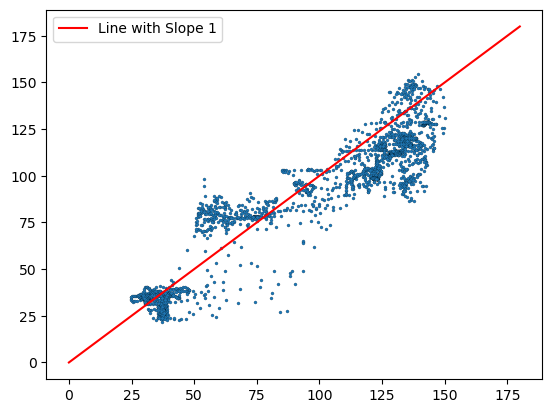

Correlation coefficient:0.9397
RMSE of Right Elbow Angle:16.5048 
Max error :60.3312  epoch_time :192.27


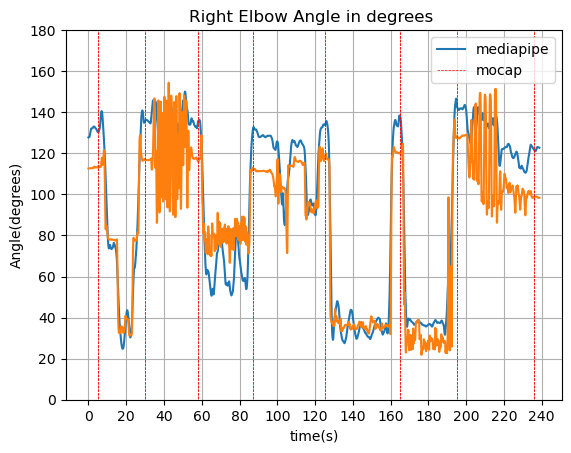

Correlation coefficient: 0.9490410384183121
Correlation coefficient:0.9490
RMSE of Left Elbow Angle:10.1826 
Max error :56.5600  at epoch_time :190.62


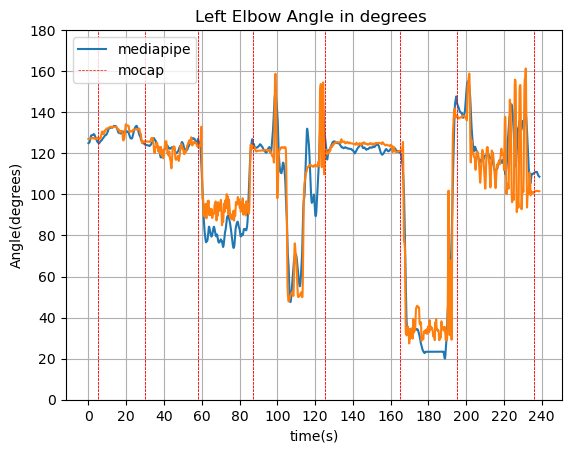

<Figure size 640x480 with 0 Axes>

In [20]:
# graph right elbow angle 

interval=10

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRightElbowAngle, mocapRightElbowAngle)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

#plotting scatter
plt.scatter(mpipeRightElbowAngle[0:-1:interval], mocapRightElbowAngle[0:-1:interval], s=5,marker='o',edgecolors='black',linewidth=0.1)
# Plot the line
plt.plot(np.linspace(0, 180, 100), np.linspace(0, 180, 100), label='Line with Slope 1', color='red')
plt.legend()
plt.show()

pvt(mpipeRightElbowAngle,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapRightElbowAngle,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('Right Elbow Angle in degrees ')
plt.ylim(0,180)
rmse,me,me_i=errors(mocapRightElbowAngle,mpipeRightElbowAngle)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of Right Elbow Angle:'+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeLeftElbowAngle, mocapLeftElbowAngle)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

#test graph left elbow angle 
pvt(mpipeLeftElbowAngle,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapLeftElbowAngle,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('Left Elbow Angle in degrees ')
plt.ylim(0,180)
rmse,me,me_i=errors(mocapLeftElbowAngle,mpipeLeftElbowAngle)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of Left Elbow Angle:'+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.show()

# Clear the figure for the next graph
plt.clf()

In [21]:
def shoulder_frame(S,E,W):
    """"
        Find the vectors describing the local x,y,z axes of shoulder
    Parameters
    ----------
    S : shoulder point
    E : elbow point
    W : wrist point
        
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """
    try:
        S,E,W=np.array(S),np.array(E),np.array(W)
        upperarm=E-S
        lowerarm=W-E

        y=upperarm
        x=-np.cross(upperarm,lowerarm)
        z=np.cross(x,y)
        return np.array([x,y,z]).T
    except:
        print('error in shoulder_frame')
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

def tr_frame(LS,RS,TR):
    """"
        Find the vectors describing the local x,y,z axes of trunk
    Parameters
    ----------
    LS : left shoulder point
    RS : right shoulder point
    TR : trunk/chest point
    
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """
    try:
        LS,RS,TR=np.array(LS),np.array(RS),np.array(TR)
        v1=LS-RS
        v2=TR-RS

        basis=gram_schmidt([v1,v2])

        try:
            v1,v2=basis[0],basis[1]

        except:
            print('error in tr_frame')
            return np.nan
        v3=np.cross(v1,v2)

        return np.array([v1,v2,v3]).T

    except:
        print('error in tr_frame')
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

def gram_schmidt(vectors):
    """
        Orthonormalize a set of vectors using the Gram-Schmidt process.

    Parameters
    ----------
    vectors : list of numpy.ndarray
        A list of vectors to be orthonormalized.

    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each row represents a vector.
    """
    basis = []
    for v in vectors:
        w = v - sum(np.dot(v,b)*b for b in basis)
        if (abs(w) > 1.0e-13).any():
            basis.append(w/np.linalg.norm(w))
        else:   
            print('zero vector detected')
        if np.linalg.norm(w/np.linalg.norm(w)) > 1.001 or np.linalg.norm(w/np.linalg.norm(w)) < 0.999:
            print(np.linalg.norm(w/np.linalg.norm(w))) 
        
    return np.array(basis)


def rotation_matrix(frame1, frame2):
    """
    Calculate the rotation matrix that transforms frame1 to frame2.
    :param frame1: 3x3 numpy array representing the first coordinate frame
    :param frame2: 3x3 numpy array representing the second coordinate frame
    :return: 3x3 numpy array representing the rotation matrix
    """
    try:
        R = np.dot(frame2, np.linalg.inv(frame1))
        return R
    except:
        print('error in roation matrix calculation')
        print(frame1,frame2)
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

In [22]:
# callibrating shoulders and trunk

# setting the calibration to 2 seconds in the video
mpipe_cf = 200
mocap_cf = 200
RSC_mpipe=shoulder_frame([df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                         [df_mpipe['RE_x'][mpipe_cf],df_mpipe['RE_y'][mpipe_cf],df_mpipe['RE_z'][mpipe_cf]],
                         [df_mpipe['RW_x'][mpipe_cf],df_mpipe['RW_y'][mpipe_cf],df_mpipe['RW_z'][mpipe_cf]])

LSC_mpipe=shoulder_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                         [df_mpipe['LE_x'][mpipe_cf],df_mpipe['LE_y'][mpipe_cf],df_mpipe['LE_z'][mpipe_cf]],
                         [df_mpipe['LW_x'][mpipe_cf],df_mpipe['LW_y'][mpipe_cf],df_mpipe['LW_z'][mpipe_cf]])

TRC_mpipe=tr_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                   [df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                   [df_mpipe['TR_x'][mpipe_cf],df_mpipe['TR_y'][mpipe_cf],df_mpipe['TR_z'][mpipe_cf]])

RSC_mocap=shoulder_frame([df_mocap['RS_x'][mocap_cf],df_mocap['RS_y'][mocap_cf],df_mocap['RS_z'][mocap_cf]],
                         [df_mocap['RE_x'][mocap_cf],df_mocap['RE_y'][mocap_cf],df_mocap['RE_z'][mocap_cf]],
                         [df_mocap['RW_x'][mocap_cf],df_mocap['RW_y'][mocap_cf],df_mocap['RW_z'][mocap_cf]])

LSC_mocap=shoulder_frame([df_mocap['LS_x'][mocap_cf],df_mocap['LS_y'][mocap_cf],df_mocap['LS_z'][mocap_cf]],
                         [df_mocap['LE_x'][mocap_cf],df_mocap['LE_y'][mocap_cf],df_mocap['LE_z'][mocap_cf]],
                         [df_mocap['LW_x'][mocap_cf],df_mocap['LW_y'][mocap_cf],df_mocap['LW_z'][mocap_cf]])

TRC_mocap=tr_frame([df_mocap['LS_x'][mocap_cf],df_mocap['LS_y'][mocap_cf],df_mocap['LS_z'][mocap_cf]],
                   [df_mocap['RS_x'][mocap_cf],df_mocap['RS_y'][mocap_cf],df_mocap['RS_z'][mocap_cf]],
                   [df_mocap['TR_x'][mocap_cf],df_mocap['TR_y'][mocap_cf],df_mocap['TR_z'][mocap_cf]])

In [23]:
# calculating the euler angles

# mpipe values
mpipeRSFE,mpipeRSAA,mpipeRSIE=[],[],[]
mpipeLSFE,mpipeLSAA,mpipeLSIE=[],[],[]
mpipeTRFB,mpipeTRLR,mpipeTRRO=[],[],[]

# Elbow Angle threshold for calculating internal/external rotation angle
eath=160

for i in range(len(df_mpipe['epoch_time'].tolist())):

    # finding the ith shoulder/trunk frames
    mpipeRSF=shoulder_frame([df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],
                            [df_mpipe['RE_x'][i],df_mpipe['RE_y'][i],df_mpipe['RE_z'][i]],
                            [df_mpipe['RW_x'][i],df_mpipe['RW_y'][i],df_mpipe['RW_z'][i]])
   
    mpipeLSF=shoulder_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                            [df_mpipe['LE_x'][i],df_mpipe['LE_y'][i],df_mpipe['LE_z'][i]],
                            [df_mpipe['LW_x'][i],df_mpipe['LW_y'][i],df_mpipe['LW_z'][i]])
   
    mpipeTRF=tr_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                      [df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],  
                      [df_mpipe['TR_x'][i],df_mpipe['TR_y'][i],df_mpipe['TR_z'][i]])
    
    # finding the rotation matrix from callibration trunk frame to ith trunk frame
    mpipeTR_rotmat=rotation_matrix(TRC_mpipe,mpipeTRF)

    # rotating shoulder callibration frame by same the rotation matrix
    mpipe_rotated_RS_Cframe=mpipeTR_rotmat@RSC_mpipe
    mpipe_rotated_LS_Cframe=mpipeTR_rotmat@LSC_mpipe


    # now finding rotation matrix from rotated shoulder callibration frame to ith shoulder frame
    mpipeRS_rotmat=rotation_matrix(RSC_mpipe,mpipeRSF)
    mpipeLS_rotmat=rotation_matrix(LSC_mpipe,mpipeLSF)

    # finding euler angles from rotation matrices
    RSeuler=rotation_angles(mpipeRS_rotmat)
    LSeuler=rotation_angles(mpipeLS_rotmat)
    TReuler=rotation_angles(mpipeTR_rotmat)

    # appending to angle lists
    mpipeRSFE.append(RSeuler[0])
    mpipeRSAA.append(RSeuler[1])
    if mpipeRightElbowAngle[i] < eath:
        mpipeRSIE.append(RSeuler[2])
    else:
        mpipeRSIE.append(np.nan)

    mpipeLSFE.append(LSeuler[0])
    mpipeLSAA.append(LSeuler[1])
    if mpipeLeftElbowAngle[i] < eath:
        mpipeLSIE.append(LSeuler[2])
    else:
        mpipeLSIE.append(np.nan)

    mpipeTRFB.append(TReuler[0])
    mpipeTRLR.append(TReuler[1])
    mpipeTRRO.append(TReuler[2])

# mocap values
mocapRSFE,mocapRSAA,mocapRSIE=[],[],[]
mocapLSFE,mocapLSAA,mocapLSIE=[],[],[]
mocapTRFB,mocapTRLR,mocapTRRO=[],[],[]

for i in range(len(df_mocap['epoch_time'].tolist())):

    # finding the ith shoulder/trunk frames
    mocapRSF=shoulder_frame([df_mocap['RS_x'][i],df_mocap['RS_y'][i],df_mocap['RS_z'][i]],
                            [df_mocap['RE_x'][i],df_mocap['RE_y'][i],df_mocap['RE_z'][i]],
                            [df_mocap['RW_x'][i],df_mocap['RW_y'][i],df_mocap['RW_z'][i]])
   
    mocapLSF=shoulder_frame([df_mocap['LS_x'][i],df_mocap['LS_y'][i],df_mocap['LS_z'][i]],
                            [df_mocap['LE_x'][i],df_mocap['LE_y'][i],df_mocap['LE_z'][i]],
                            [df_mocap['LW_x'][i],df_mocap['LW_y'][i],df_mocap['LW_z'][i]])
   
    mocapTRF=tr_frame([df_mocap['LS_x'][i],df_mocap['LS_y'][i],df_mocap['LS_z'][i]],
                      [df_mocap['RS_x'][i],df_mocap['RS_y'][i],df_mocap['RS_z'][i]],  
                      [df_mocap['TR_x'][i],df_mocap['TR_y'][i],df_mocap['TR_z'][i]])
   
    # finding the rotation matrix from callibration trunk frame to ith trunk frame
    mocapTR_rotmat=rotation_matrix(TRC_mocap,mocapTRF)

    # rotating shoulder callibration frame by same the rotation matrix
    mocap_rotated_RS_Cframe=mocapTR_rotmat@RSC_mocap
    mocap_rotated_LS_Cframe=mocapTR_rotmat@LSC_mocap

    # now finding rotation matrix from rotated shoulder callibration frame to ith shoulder frame
    mocapRS_rotmat=rotation_matrix(RSC_mocap,mocapRSF)
    mocapLS_rotmat=rotation_matrix(LSC_mocap,mocapLSF)

    # finding euler angles from rotation matrices
    RSeuler=rotation_angles(mocapRS_rotmat)
    LSeuler=rotation_angles(mocapLS_rotmat)
    TReuler=rotation_angles(mocapTR_rotmat)

    # appending to angle lists
    mocapRSFE.append(RSeuler[0])
    mocapRSAA.append(RSeuler[1])
    if mocapRightElbowAngle[i] < eath:
        mocapRSIE.append(RSeuler[2])
    else:
        mocapRSIE.append(np.nan)

    mocapLSFE.append(LSeuler[0])
    mocapLSAA.append(LSeuler[1])
    if mocapLeftElbowAngle[i] < eath:
        mocapLSIE.append(LSeuler[2])
    else:
        mocapLSIE.append(np.nan)
    
    mocapTRFB.append(TReuler[0])
    mocapTRLR.append(TReuler[1])
    mocapTRRO.append(TReuler[2])

Correlation coefficient: 0.3508806961071816
Correlation coefficient:0.3509
RMSE of trunk forward/backward: 7.7342 
Max error :40.0036  epoch_time :25.19


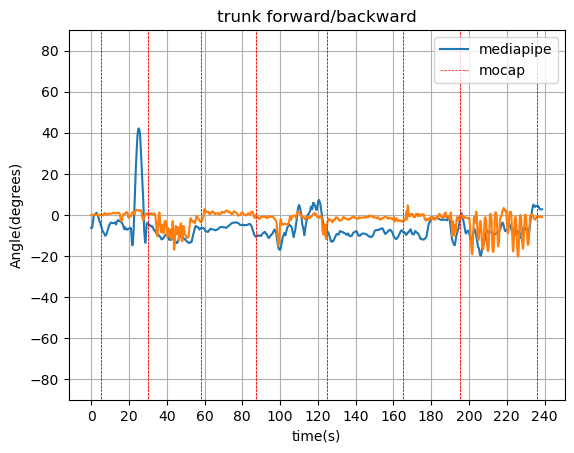

Correlation coefficient: 0.6939690184605318
Correlation coefficient:0.6940
RMSE of trunk left/right: 3.0679 
Max error :12.2745  epoch_time :206.19


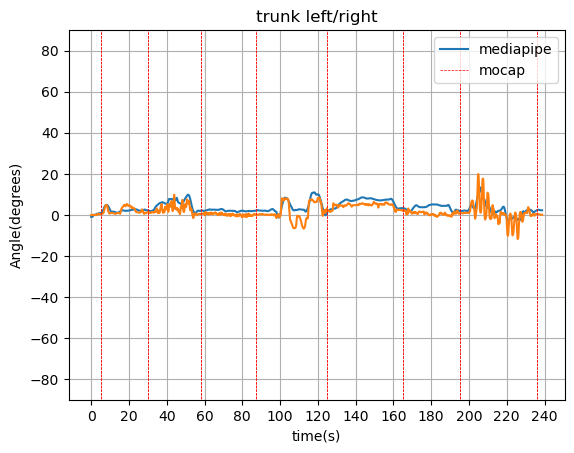

Correlation coefficient: 0.788094521828153
Correlation coefficient:0.7881
RMSE of trunk rotation: 4.9982 
Max error :24.2145  epoch_time :226.05


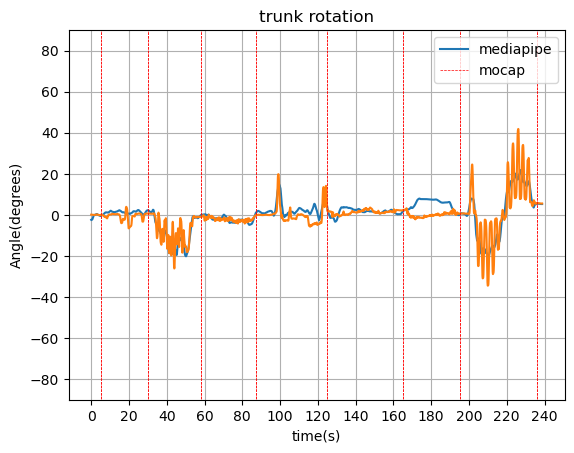

<Figure size 640x480 with 0 Axes>

In [24]:
# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeTRFB, mocapTRFB)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

# plotting the trunk angles
pvt(mpipeTRFB,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapTRFB,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('trunk forward/backward')
plt.ylim(-90,90)
rmse,me,me_i=errors(mocapTRFB,mpipeTRFB)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of trunk forward/backward: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)
# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeTRLR, mocapTRLR)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeTRLR,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapTRLR,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('trunk left/right')
plt.ylim(-90,90)
rmse,me,me_i=errors(mocapTRLR,mpipeTRLR)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of trunk left/right: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeTRRO, mocapTRRO)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeTRRO,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapTRRO,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('trunk rotation')
plt.ylim(-90,90)
rmse,me,me_i=errors(mocapTRRO,mpipeTRRO)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of trunk rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.show()

# Clear the figure for the next graph
plt.clf()

Correlation coefficient: 0.8329725950321499
Correlation coefficient:0.8330
RMSE of right shoulder flexion/extension: 10.0542 
Max error :39.0302  epoch_time :215.30


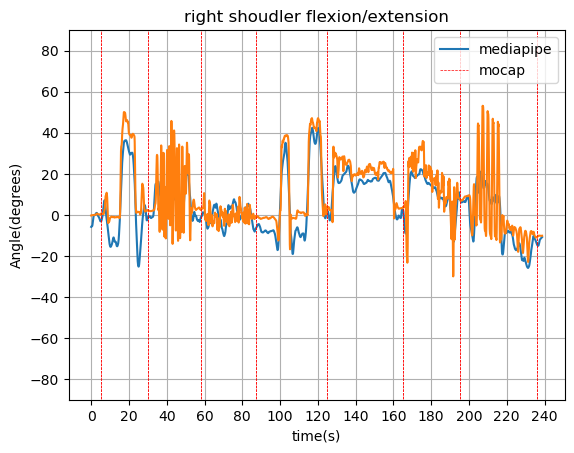

Correlation coefficient: 0.6462264445729696
Correlation coefficient:0.6462
RMSE of right shoulder abduction/adduction: 7.3663 
Max error :36.1894  epoch_time :215.65


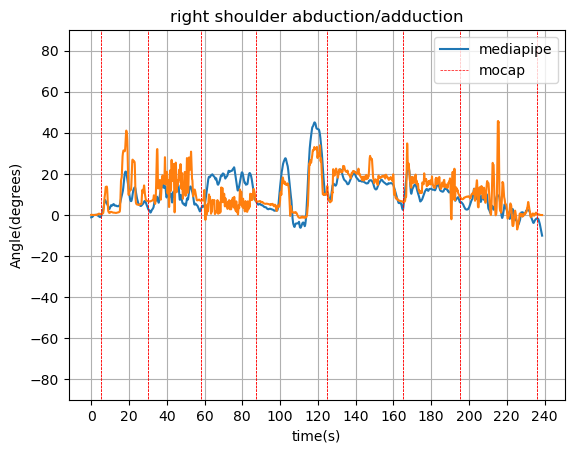

Correlation coefficient: 0.4599512758911964
Correlation coefficient:0.4600
RMSE of right shoulder internal/external rotation: 21.0806 
Max error :56.4162  epoch_time :207.46


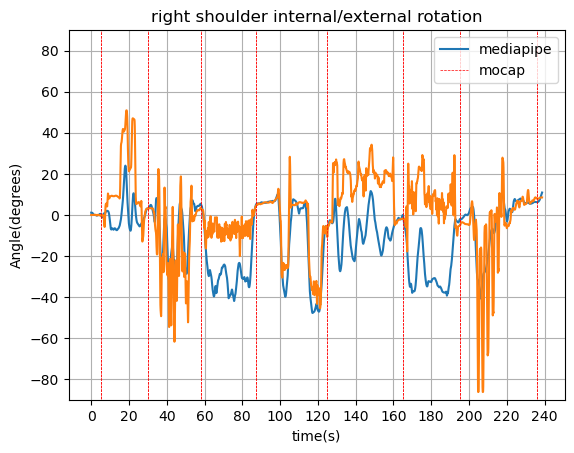

Correlation coefficient: 0.6997656561632977
Correlation coefficient:0.6998
RMSE of left shoulder flexion/extension: 10.8927 
Max error :52.7071  epoch_time :226.07


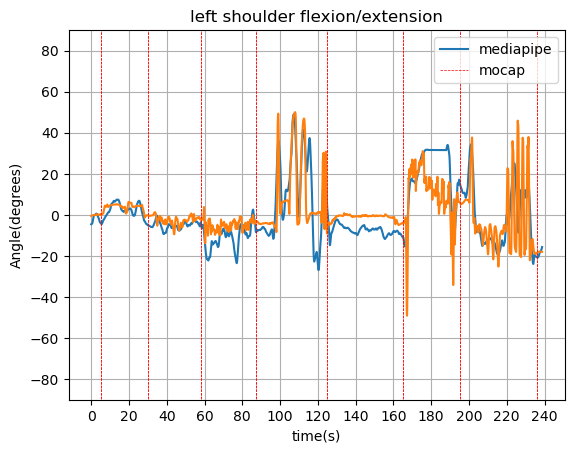

Correlation coefficient: 0.6447009373352975
Correlation coefficient:0.6447
RMSE of left shoulder abduction/adduction: 6.1216 
Max error :25.9726  epoch_time :231.54


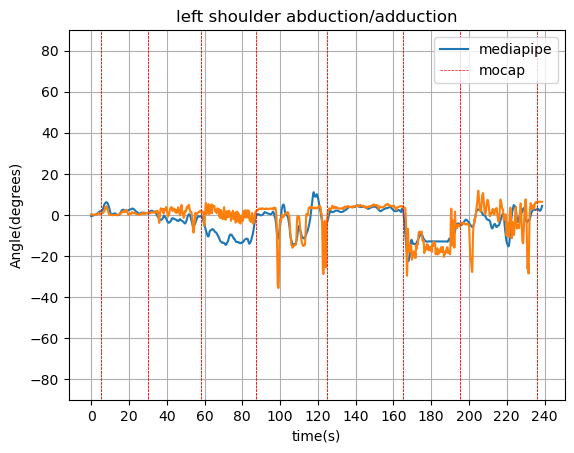

Correlation coefficient: 0.4599512758911964
Correlation coefficient:0.4600
RMSE of left shoulder internal/external rotation: 12.6129 
Max error :67.6352  epoch_time :226.04


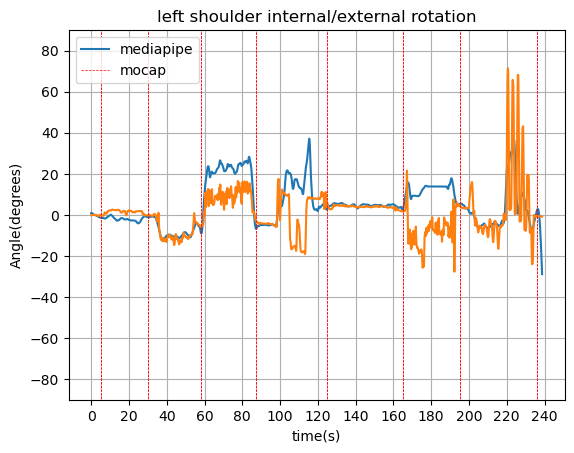

<Figure size 640x480 with 0 Axes>

In [25]:
# Plotting the shoulder angles

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRSFE, mocapRSFE)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeRSFE,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapRSFE,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.legend(['mediapipe','mocap'])
plt.title('right shoudler flexion/extension')
plt.ylim(-90,90)
rmse,me,me_i=errors(mocapRSFE,mpipeRSFE)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of right shoulder flexion/extension: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRSAA, mocapRSAA)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeRSAA,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapRSAA,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('right shoulder abduction/adduction')
plt.ylim(-90,90)
rmse,me,me_i=errors(mocapRSAA,mpipeRSAA)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of right shoulder abduction/adduction: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.show()

# Clear the figure for the next graph
plt.clf()

mpipeRSIE1, mocapRSIE1 = np.array(mpipeRSIE), np.array(mocapRSIE)
mask = ~np.isnan(mpipeRSIE1) & ~np.isnan(mocapRSIE1) 
mpipeRSIE1 = mpipeRSIE1[mask]
mocapRSIE1 = mocapRSIE1[mask]

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRSIE1, mocapRSIE1)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeRSIE,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapRSIE,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('right shoulder internal/external rotation')
plt.ylim(-90,90)
rmse,me,me_i = errors(mocapRSIE,mpipeRSIE)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of right shoulder internal/external rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.show()

# Clear the figure for the next graph
plt.clf()


# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeLSFE, mocapLSFE)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeLSFE,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapLSFE,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('left shoulder flexion/extension')
plt.ylim(-90,90)
rmse, me , me_i =errors(mocapLSFE,mpipeLSFE)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of left shoulder flexion/extension: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeLSAA, mocapLSAA)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeLSAA,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapLSAA,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('left shoulder abduction/adduction')
plt.ylim(-90,90)
rmse,me,me_i=errors(mocapLSAA,mpipeLSAA)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of left shoulder abduction/adduction: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.show()

# Clear the figure for the next graph
plt.clf()

mpipeLSIE1, mocapLSIE1 = np.array(mpipeLSIE), np.array(mocapLSIE)
mask = ~np.isnan(mpipeLSIE1) & ~np.isnan(mocapLSIE1)
mpipeLSIE1 = mpipeLSIE1[mask]
mocapLSIE1 = mocapLSIE1[mask]

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRSIE1, mocapRSIE1)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeLSIE,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapLSIE,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('left shoulder internal/external rotation')
plt.ylim(-90,90)
rmse, me , me_i = errors(mocapLSIE,mpipeLSIE)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of left shoulder internal/external rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.show()

# Clear the figure for the next graph
plt.clf()


In [26]:
# Showing data in a pptx
graph_dic={'Right Elbow Angle':[mocapRightElbowAngle,mpipeRightElbowAngle],'Left Elbow Angle':[mocapLeftElbowAngle,mpipeLeftElbowAngle],
           'Trunk forward/backward':[mocapTRFB,mpipeTRFB],'Trunk left/right':[mocapTRLR,mpipeTRLR], 'Trunk rotation':[mocapTRRO,mpipeTRRO],
           'Right shoulder abduction/adduction':[mocapRSAA,mpipeRSAA],'Right shoulder flexion/extension':[mocapRSFE,mpipeRSFE],'Right shoulder rotation':[mocapRSIE,mpipeRSIE],
           'Left shoulder abduction/adduction':[mocapLSAA,mpipeLSAA],'Left shoulder flexion/extension':[mocapLSFE,mpipeLSFE],'Left shoulder rotation':[mocapLSIE,mpipeLSIE]}
graph_names=list(graph_dic.keys())

# delete the previous graphs pptx if it exists
id = pth.split('\\')[-1].split('_')[-1]
try:
    os.remove(pth+'\\graphs_'+id+'.pptx')
except:
    pass
# Save the graphs to the PowerPoint presentation
tot=0
error_list=[]
graph_no=0
for graph,error,name in zip(graphs,RMSEs,graph_names):
    save_graph_to_pptx(prs, graph, error)
    err=float(error.split(':')[2].split('\n')[0].strip())
    tot=tot+err
    error_list.append(err)
    
    if task_present:
        table_data=[]
        table_data.append(['task no:','RMSE','Max Error','correlation'])
        mocapList,mpipeList = split_list_by_indexes(graph_dic[name][0],task_index) , split_list_by_indexes(graph_dic[name][1],task_index)
        for i in range(task_no):
            mocapArray ,mpipeArray  = np.array(mocapList[i]) ,np.array(mpipeList[i])
            mask = ~np.isnan(mocapArray) & ~np.isnan(mpipeArray) 
            mocapArray = mocapArray[mask]
            mpipeArray = mpipeArray[mask]
            if i == 0:
                continue
            rmse,me,me_i=errors(mocapArray,mpipeArray)
            corr=pearsonr(mocapArray,mpipeArray)[0]
            table_data.append([f"task{i}",f"{rmse:.4f}",f"{me:.4f}",f"{corr:.4f}"])
        prs=add_table_slide(prs,name,table_data)
        
    graph_no+=1
        
    
# Add a slide with a title and content layout
slide_layout = prs.slide_layouts[6]
slide = prs.slides.add_slide(slide_layout)

left = Inches(0.5)
top = Inches(1)
width = Inches(6)
height = Inches(4.5)

# Define the number of rows and columns for the table
num_rows = 12
num_cols = 3

# Define the width and height of the table
table_width = Inches(9.5)  # Adjust the value according to your desired width
table_height = Inches(3.5)  # Adjust the value according to your desired height

# Calculate the width and height of each cell in the table
cell_width = int(table_width / num_cols)
cell_height = int(table_height / num_rows)

# Add the table to the slide
left = top = Inches(0.25)  # Adjust the values to position the table on the slide
table = slide.shapes.add_table(num_rows, num_cols, left, top, table_width, table_height).table

# Set the column widths
for i in range(num_cols):
    table.columns[i].width = cell_width

# Set the row heights
for i in range(num_rows):
    table.rows[i].height = cell_height

# Populate the table with content
table.cell(0, 0).text = "Angle"
table.cell(0, 1).text = "RMSE"
table.cell(0, 2).text = "Correlation"

for i in range(1,12):
    table.cell(i,0).text = graph_names[i-1]
    table.cell(i,1).text = str(error_list[i-1])
    table.cell(i,2).text = str(f"{corr_list[i-1]:.4f}")

# Add the description as a text box
txBox = slide.shapes.add_textbox(left, top + height + Inches(1.5), width, Inches(1))
tf = txBox.text_frame
p = tf.add_paragraph()
p.text = 'Average RMSE: '+str(f'{tot/len(graphs):.4f}')

print('Average RMSE: '+str(tot/len(graphs)))

id = pth.split('\\')[-1].split('_')[-1]

# Save the presentation
prs.save(pth+'\\graphs_'+id+'.pptx')

Average RMSE: 10.056


In [27]:
s=[]
for i in df_mpipe.columns.tolist():
    if '' in i:
        # Calculate the correlation coefficient and p-value
        correlation, p_value = pearsonr(df_mocap[i],df_mpipe[i])
        # Print the correlation coefficient and p-value
        print(i," Correlation coefficient:", correlation)
        s.append(correlation)
s=np.array(s)
print('mean',s.mean())

epoch_time  Correlation coefficient: 1.0
LS_x  Correlation coefficient: 0.7939461760320501
LS_y  Correlation coefficient: 0.623400301255002
LS_z  Correlation coefficient: 0.8221966580930402
LE_x  Correlation coefficient: 0.612602460975674
LE_y  Correlation coefficient: 0.549458979342149
LE_z  Correlation coefficient: 0.5095257979737906
LW_x  Correlation coefficient: 0.8585698944138682
LW_y  Correlation coefficient: 0.9672595659713779
LW_z  Correlation coefficient: 0.8864114649587544
RS_x  Correlation coefficient: 0.7668773054790782
RS_y  Correlation coefficient: 0.8092469991261035
RS_z  Correlation coefficient: 0.837694857239726
RE_x  Correlation coefficient: 0.6630208495964218
RE_y  Correlation coefficient: 0.7320065027444533
RE_z  Correlation coefficient: 0.7473460527949095
RW_x  Correlation coefficient: 0.8437289298849273
RW_y  Correlation coefficient: 0.9792133753879646
RW_z  Correlation coefficient: 0.8983548279103829
TR_x  Correlation coefficient: 0.6433398904713723
TR_y  Correla

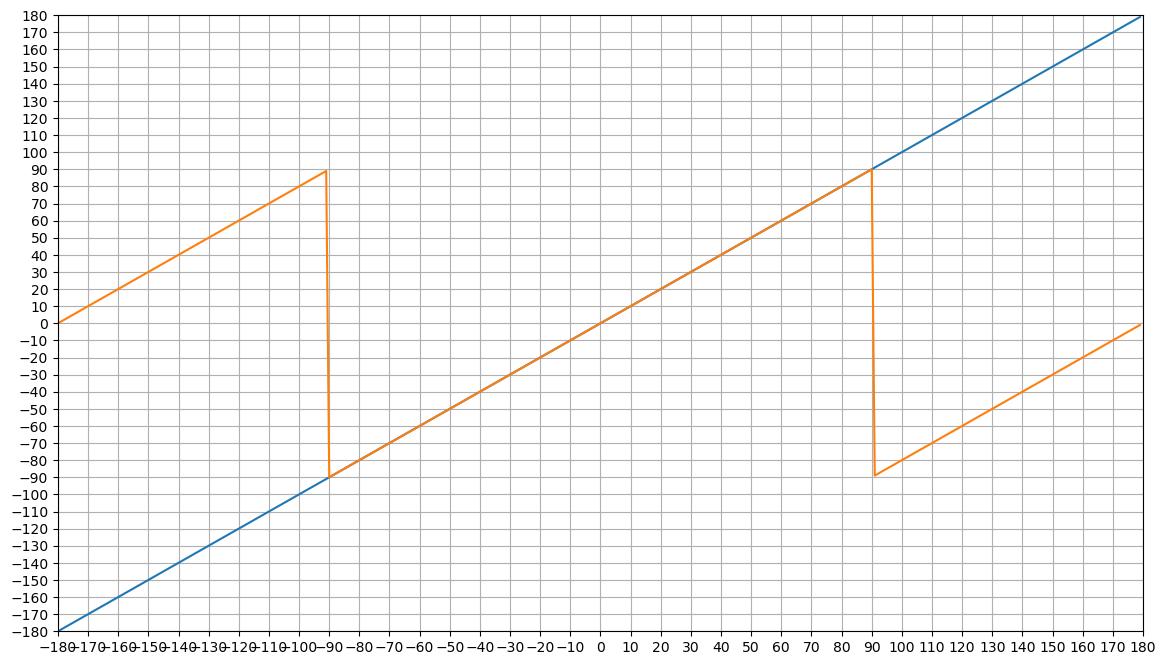

In [28]:
from matplotlib.ticker import MultipleLocator

myval = []
nval,cval=[],[]
start,stop= -180,180
for i in range(start,stop):
    myval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))

    theta=i
    c=np.tan(np.deg2rad(theta))
    theta_check = False
    if theta < 0: 
        theta_check = True 
    
    if not theta_check:

        if np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))) < 0:
            cval.append(180+np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))
        else:
            cval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))
    else:

        if np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))) < 0:
            cval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))
        else:
            cval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i))))-180)

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the data
ax.plot(range(start,stop),cval)
ax.plot(range(start,stop),myval)

# Set the major ticks on the y-axis to be at multiples of 10
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(10))

# Show the grid lines
ax.grid(True)
plt.ylim(-180,180)
plt.xlim(-180,180)
plt.show()